# MRCNN Attention

### Introduction
Here, we attempt to improve the Mask R-CNN model to achieve a higher mIoU score. Based on the results, However, these results are not ideal as the model seems to focus on noise and irrelevant background information. We attempt to summarize and discuss the reasons for the decline in the model's classification performance and propose possible future improvements.

In this new model, we used the same data processing method mentioned earlier (with a training set of 2400 images, a validation set of 1200 images, and a test set of 1000 images).

The new model attempts to introduce the SEBlock to implement the attention mechanism in the original architecture. We tried to improve the model's representation ability by recalibrating the weights of each channel using this method. The SEBlock was added to specific ResNet layers (we chose layers 2 and 3 here, as we believe applying the attention module to shallow layers may cause the model to focus too much on edge details, which could worsen classification performance), enhancing the feature maps in the Feature Pyramid Network (FPN). For the training process, we used a more stable Adam optimizer with a learning rate of 0.001 and a weight decay factor of 0.0005. We also used the StepLR scheduler. The model was trained for eight epochs on the same dataset, with a final validation loss of 0.62. However, we found that the classification performance worsened.

### Results Analysis
Our mIoU scores were 0.7832 for the turtle, 0.7340 for the flippers, and 0.8269 for the head, and overall mean mIoU of 0.7813, indicating that the model did not improve in any of the three categories. This suggests that the model might have extracted many irrelevant features due to the addition of the attention mechanism.

In the future, we can try to continue adjusting the locations where the attention mechanism is added, focusing on the high-level global feature extraction stages or using deeper networks. Alternatively, we could consider that the attention mechanism may not be suitable for this task, as the classification task for turtles may not require attention to many edge details. ResNet-50 might already be sufficient for feature extraction.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import cv2
import pandas as pd
import numpy as np
import torchvision
import os
import random
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

# Custom Transforms
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            image = F.hflip(image)
            width = image.shape[-1]

            # Flip bounding boxes
            if 'boxes' in target:
                boxes = target['boxes']
                boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
                target['boxes'] = boxes

            # Flip masks
            if 'masks' in target:
                target['masks'] = target['masks'].flip(-1)
        return image, target

# Dataset class
class SeaTurtleDataset(Dataset):
    def __init__(self, img_dir, ann_file, split='train', transforms=None, limit_data=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.transforms = transforms

        # Load metadata file
        metadata = pd.read_csv('turtles-data/data/metadata_splits.csv')

        # Filter for the specified split
        self.img_ids = metadata[metadata['split_open'] == split]['id'].tolist()

        # Limit the data if specified
        if limit_data is not None:
            self.img_ids = self.img_ids[:limit_data]

        # Filter out img_ids with missing images
        valid_img_ids = []
        for img_id in self.img_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            if os.path.exists(img_path):
                valid_img_ids.append(img_id)
            else:
                print(f"Image not found and will be skipped: {img_path}")
        self.img_ids = valid_img_ids

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert image to PIL Image for transforms
        img = F.to_pil_image(img)

        # Get annotations for the image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Prepare target
        target = {}
        boxes = []
        labels = []
        masks = []
        areas = []
        iscrowd = []

        for ann in anns:
            x, y, width, height = ann['bbox']
            boxes.append([x, y, x + width, y + height])
            labels.append(ann['category_id'])
            ann_mask = self.coco.annToMask(ann)
            masks.append(ann_mask)
            areas.append(ann['area'])
            iscrowd.append(ann.get('iscrowd', 0))

        # If no annotations, create empty target
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.tensor([], dtype=torch.int64)
            masks = torch.zeros((0, img_info['height'], img_info['width']), dtype=torch.uint8)
            areas = torch.tensor([], dtype=torch.float32)
            iscrowd = torch.tensor([], dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.stack([torch.as_tensor(m, dtype=torch.uint8) for m in masks])
            areas = torch.as_tensor(areas, dtype=torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = torch.tensor([img_id])
        target['area'] = areas
        target['iscrowd'] = iscrowd

        # Apply any transforms
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [2]:
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = x.mean((2, 3), keepdim=False)  
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y


In [3]:
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = x.mean((2, 3), keepdim=False)  
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y

class SE_ResNet50_FPN(nn.Module):
    def __init__(self):
        super(SE_ResNet50_FPN, self).__init__()
        # Create a resnet backbone with FPN
        self.backbone = resnet_fpn_backbone('resnet50', weights='IMAGENET1K_V1')
        # Add SE block to a specific layer in the backbone
        self.se_block2 = SEBlock(in_channels=256)  # Adjust based on which level you want to add SEBlock
        self.se_block3 = SEBlock(in_channels=256)
        
        # Set the output channels for the backbone
        self.out_channels = 256  # This should match the output of FPN

    def forward(self, x):
        # Get the features from the backbone (which returns 4 feature maps by default in FPN)
        features = self.backbone(x)
        
        # Choose a specific feature map to apply the SE block
        # Here we choose the first layer as an example, this could be adjusted based on your design
        features['2'] = self.se_block2(features['2'])
        features['3'] = self.se_block3(features['3'])
        
        return features



def get_model_with_attention(num_classes):
    # Create a backbone with SEBlock integrated
    backbone_with_attention = SE_ResNet50_FPN()
    # Define the Mask R-CNN model with custom backbone
    model = MaskRCNN(backbone_with_attention, num_classes=num_classes)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the box predictor with a new one for our classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    hidden_layer = 256

    # Replace the mask predictor with a new one for our classes
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    return model

# Number of classes (including background)
num_classes = 4  # Background + turtle + flipper + head
model = get_model_with_attention(num_classes)

C:\Users\1\anaconda3\envs\9517\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [4]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader

# Transform function
def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

# Use the same transformations for train and validation for simplicity
train_transforms = get_transform(train=True)
valid_transforms = get_transform(train=False)
test_transforms = get_transform(train=False)

image_root = 'turtles-data/data'
annotation_file = 'turtles-data/data/annotations.json'

# Use the custom get_transform function
train_transforms = get_transform(train=True)
valid_transforms = get_transform(train=False)

# Create datasets
train_dataset = SeaTurtleDataset(image_root, annotation_file, split='train', transforms=train_transforms, limit_data=2400)
valid_dataset = SeaTurtleDataset(image_root, annotation_file, split='valid', transforms=valid_transforms, limit_data=1200)
test_dataset = SeaTurtleDataset(image_root, annotation_file, split='test', transforms=test_transforms, limit_data=1000)

# Define training and validation data loaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

# Learning rate scheduler (optional)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


loading annotations into memory...
Done (t=4.81s)
creating index...
index created!
loading annotations into memory...
Done (t=4.72s)
creating index...
index created!
loading annotations into memory...
Done (t=3.85s)
creating index...
index created!


In [5]:
def compute_validation_loss(model, data_loader, device):
    # Save the original training state
    was_training = model.training

    # Set the model to training mode to compute validation loss
    model.train()
    val_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

            # Forward pass to get the loss dictionary
            loss_dict = model(images, targets)
            # Compute total loss
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    val_loss /= len(data_loader)

    # Restore the original training state
    if not was_training:
        model.eval()

    return val_loss

In [6]:
num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        i += 1
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_dataloader)}], Loss: {losses.item():.4f}")

    # Update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    # Compute validation loss
    val_loss = compute_validation_loss(model, valid_dataloader, device)
    print(f"Validation Loss after Epoch {epoch+1}: {val_loss:.4f}")

Epoch [1/8], Step [10/300], Loss: 1.5136
Epoch [1/8], Step [20/300], Loss: 1.1208
Epoch [1/8], Step [30/300], Loss: 1.2093
Epoch [1/8], Step [40/300], Loss: 1.6206
Epoch [1/8], Step [50/300], Loss: 1.2365
Epoch [1/8], Step [60/300], Loss: 1.1807
Epoch [1/8], Step [70/300], Loss: 1.2620
Epoch [1/8], Step [80/300], Loss: 1.0793
Epoch [1/8], Step [90/300], Loss: 1.1987
Epoch [1/8], Step [100/300], Loss: 1.3312
Epoch [1/8], Step [110/300], Loss: 1.1167
Epoch [1/8], Step [120/300], Loss: 1.0603
Epoch [1/8], Step [130/300], Loss: 1.1500
Epoch [1/8], Step [140/300], Loss: 1.0989
Epoch [1/8], Step [150/300], Loss: 1.0974
Epoch [1/8], Step [160/300], Loss: 1.1080
Epoch [1/8], Step [170/300], Loss: 1.0527
Epoch [1/8], Step [180/300], Loss: 1.1936
Epoch [1/8], Step [190/300], Loss: 1.0856
Epoch [1/8], Step [200/300], Loss: 1.0659
Epoch [1/8], Step [210/300], Loss: 1.1701
Epoch [1/8], Step [220/300], Loss: 1.0854
Epoch [1/8], Step [230/300], Loss: 1.0279
Epoch [1/8], Step [240/300], Loss: 1.1044
E

In [7]:
# Save the model
torch.save(model.state_dict(), 'maskrcnn_seaturtle.pth')

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 4  # Background + turtle + flipper + head
model = get_model_with_attention(num_classes)
model.load_state_dict(torch.load('maskrcnn_seaturtle.pth', map_location=device))
model.to(device)

def compute_iou(mask1, mask2):
    """Compute the IoU between two binary masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    else:
        return intersection / union

# Visualization
def visualize_predictions(model, dataset, device, num_images, score_threshold=0.5):
    model.eval()
    ious_per_class = {1: [], 2: [], 3: []}
    class_names = ['Background', 'Turtle', 'Flipper', 'Head']

    specific_images = [5, 14, 2, 29]
    good_examples = [5, 14]
    bad_examples = [2, 29]

    with torch.no_grad():
        for idx in specific_images:
            img, target = dataset[idx]
            img = img.to(device)
            output = model([img])[0]

            img_cpu = img.cpu().permute(1, 2, 0).numpy()
            img_cpu = (img_cpu * 255).astype(np.uint8)

            gt_masks = target['masks'].numpy()
            gt_labels = target['labels'].numpy()

            pred_masks = output['masks'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()

            pred_masks = pred_masks >= 0.5

            # Colors for visualization
            colors = np.array([
                [0, 0, 0],        # Background - black
                [255, 0, 0],      # Turtle - red
                [0, 255, 0],      # Flipper - green
                [0, 0, 255],      # Head - blue
            ])

            # Ground truth overlay
            gt_overlay = img_cpu.copy()
            for i in range(len(gt_masks)):
                mask = gt_masks[i]
                label = gt_labels[i]
                color = colors[label % len(colors)]
                gt_overlay[mask == 1] = (gt_overlay[mask == 1] * 0.5 + color * 0.5).astype(np.uint8)

            # Predicted overlay with IoU scores
            pred_overlay = img_cpu.copy()
            fig, ax = plt.subplots(1, 3, figsize=(20, 8))
            ax[0].imshow(img_cpu)
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            for i in range(len(pred_masks)):
                if pred_scores[i] >= score_threshold:
                    mask = pred_masks[i, 0]
                    label = pred_labels[i]
                    color = colors[label % len(colors)]
                    pred_overlay[mask == 1] = (pred_overlay[mask == 1] * 0.5 + color * 0.5).astype(np.uint8)

                    ious = []
                    for j in range(len(gt_masks)):
                        if gt_labels[j] == label:
                            gt_mask = gt_masks[j]
                            iou = compute_iou(mask, gt_mask)
                            ious.append(iou)
                        else:
                            ious.append(0)
                    if ious:
                        best_iou = max(ious)
                        ious_per_class[label].append(best_iou)
                    else:
                        best_iou = 0.0

                    y_indices, x_indices = np.where(mask == 1)
                    if len(y_indices) > 0 and len(x_indices) > 0:
                        y = y_indices[0]
                        x = x_indices[0]
                        ax[2].text(x, y, f'IoU: {best_iou:.2f}', color='white', fontsize=8, backgroundcolor="black")

            # Plotting
            ax[1].imshow(gt_overlay)
            ax[1].set_title('Ground Truth Masks')
            ax[1].axis('off')

            if idx in good_examples:
                example_type = 'Good Example'
            elif idx in bad_examples:
                example_type = 'Bad Example'
            else:
                example_type = 'Example'

            ax[2].imshow(pred_overlay)
            ax[2].set_title(f'Predicted Masks with IoU ({example_type, idx})')
            ax[2].axis('off')

            plt.show()

C:\Users\1\anaconda3\envs\9517\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\1\AppData\Local\Temp\ipykernel_10972\923333012.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

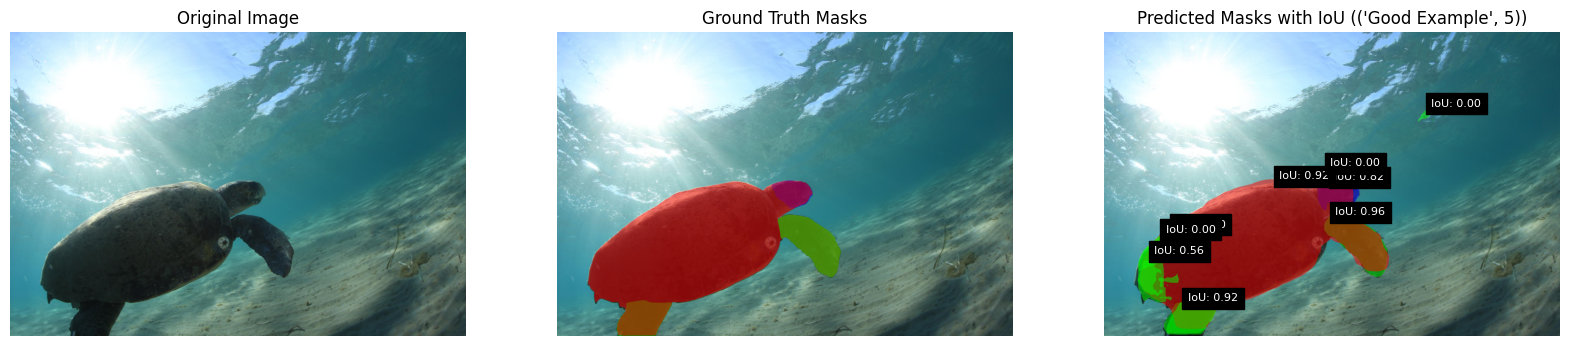

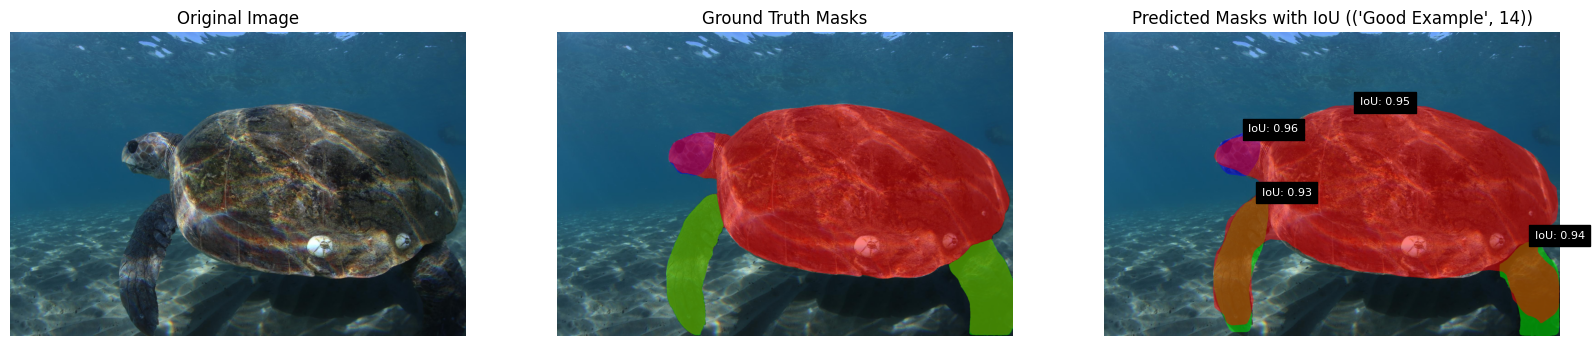

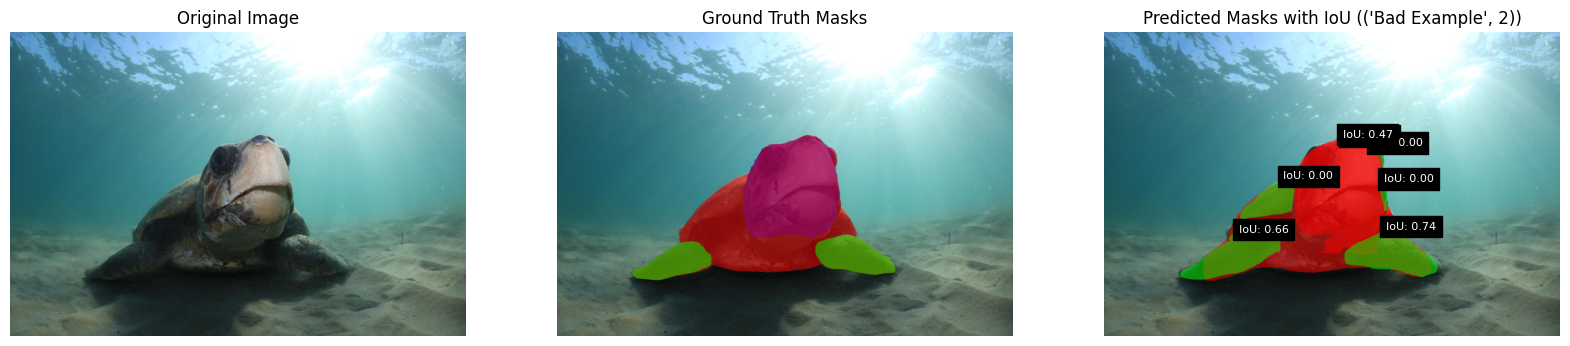

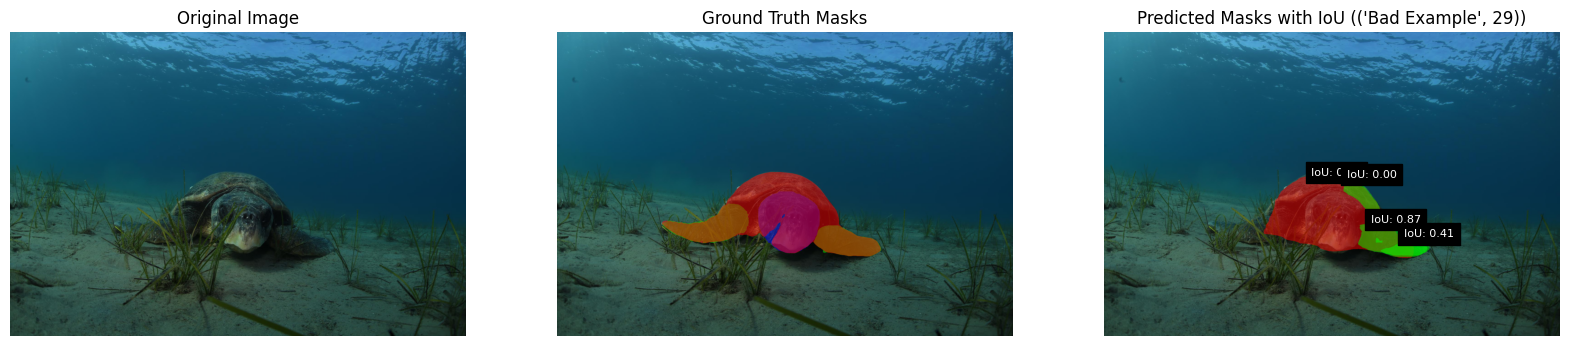

In [7]:
visualize_predictions(model, test_dataset, device, num_images=4)

In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

# Visualization and mIoU computation
def compute_and_visualize_miou(model, dataset, device, num_images=None, score_threshold=0.5):
    model.eval()
    ious_per_class = {1: [], 2: [], 3: []}
    class_names = ['Background', 'Turtle', 'Flipper', 'Head']

    num_images = num_images if num_images is not None else len(dataset)

    with torch.no_grad():
        for idx in range(num_images):
            img, target = dataset[idx]
            img = img.to(device)
            output = model([img])[0]

            img_cpu = img.cpu().permute(1, 2, 0).numpy()
            img_cpu = (img_cpu * 255).astype(np.uint8)

            gt_masks = target['masks'].numpy()
            gt_labels = target['labels'].numpy()

            pred_masks = output['masks'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()

            pred_masks = pred_masks >= 0.5

            # Collect IoU scores per class
            for i in range(len(pred_masks)):
                if pred_scores[i] >= score_threshold:
                    pred_mask = pred_masks[i, 0]
                    pred_label = pred_labels[i]

                    max_iou = 0.0
                    for j in range(len(gt_masks)):
                        if gt_labels[j] == pred_label:
                            gt_mask = gt_masks[j]
                            iou = compute_iou(pred_mask, gt_mask)
                            if not np.isnan(iou) and iou > max_iou:
                                max_iou = iou
                    if max_iou > 0:
                        ious_per_class[pred_label].append(max_iou)
    mean_ious = []
    # Compute and print mIoU per class
    for idx in range(1, len(class_names)):
        ious = ious_per_class.get(idx, [])
        mean_iou = np.mean(ious) if len(ious) > 0 else np.nan
        mean_ious.append(mean_iou)
        print(f'{class_names[idx]} mIoU: {mean_iou:.4f}')
    overall_mean_iou = np.nanmean(mean_ious)
    print(f'Overall mean mIoU: {overall_mean_iou:.4f}')
    
compute_and_visualize_miou(model, test_dataset, device, num_images=1000, score_threshold=0.5)

Turtle mIoU: 0.7832
Flipper mIoU: 0.7340
Head mIoU: 0.8269
Overall mean mIoU: 0.7813
